
# Vector Addition

In this tutorial, you will write a simple vector addition using Triton.

In doing so, you will learn about:

* The basic programming model of Triton.

* The `triton.jit` decorator, which is used to define Triton kernels.

* The best practices for validating and benchmarking your custom ops against native reference implementations.


## Compute Kernel



In [1]:
import torch

import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()


@triton.jit
def add_kernel(
    x_ptr,  # *Pointer* to first input vector.
    y_ptr,  # *Pointer* to second input vector.
    output_ptr,  # *Pointer* to output vector.
    n_elements,  # Size of the vector.
    BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
    # NOTE: `constexpr` so it can be used as a shape value.
):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

Let's also declare a helper function to (1) allocate the `z` tensor
and (2) enqueue the above kernel with appropriate grid/block sizes:



In [2]:
def add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

We can now use the above function to compute the element-wise sum of two `torch.tensor` objects and test its correctness:



In [3]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is "
    f"{torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.4024, 1.7918, 1.0686], device='cuda:0')
The maximum difference between torch and triton is 0.0


Seems like we're good to go!



## Benchmark

We can now benchmark our custom op on vectors of increasing sizes to get a sense of how it does relative to PyTorch.
To make things easier, Triton has a set of built-in utilities that allow us to concisely plot the performance of our custom ops.
for different problem sizes.



In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],  # Argument names to use as an x-axis for the plot.
        x_vals=[
            2**i for i in range(12, 28, 1)
        ],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot.
        line_vals=["triton", "torch"],  # Possible values for `line_arg`.
        line_names=["Triton", "Torch"],  # Label name for the lines.
        styles=[("blue", "-"), ("green", "-")],  # Line styles.
        ylabel="GB/s",  # Label name for the y-axis.
        plot_name="vector-add-performance",  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

We can now run the decorated function above. Pass `print_data=True` to see the performance number, `show_plots=True` to plot them, and/or
`save_path='/path/to/results/' to save them to disk along with raw CSV data:



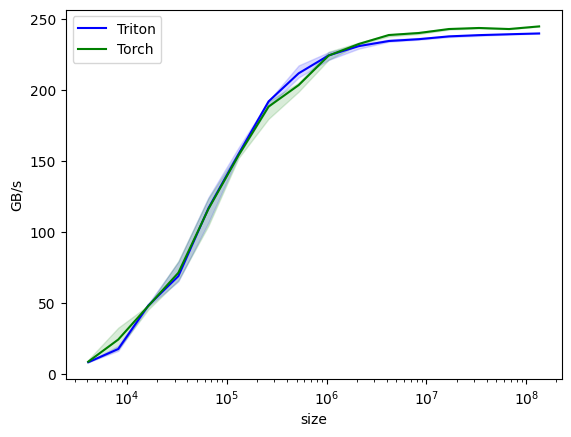

vector-add-performance:
           size      Triton       Torch
0        4096.0    8.000000    8.393443
1        8192.0   17.355933   24.000000
2       16384.0   48.000000   47.627910
3       32768.0   68.648047   71.028905
4       65536.0  116.473930  115.924529
5      131072.0  154.566035  153.600004
6      262144.0  191.625729  187.961750
7      524288.0  211.406456  203.107443
8     1048576.0  224.054704  223.927109
9     2097152.0  230.557615  232.054296
10    4194304.0  234.161674  238.384967
11    8388608.0  235.458679  239.802413
12   16777216.0  237.435833  242.613613
13   33554432.0  238.312729  243.340850
14   67108864.0  238.922484  242.606591
15  134217728.0  239.496032  244.456554


In [5]:
benchmark.run(print_data=True, show_plots=True)